### Macroeconomic phase space analysis: some first steps.

What this mini-project sets out to do is to study Brazilian macroeconomic data in what I'm calling a **phase space approach**. In classical mechanics every moving part must be described by at least two numbers: a coordinate $q$ and a momentum $p$. (So for example $N$ particles in three-dimensional phenomenological reality live in a phase space with $6N$ dimensions). The phase space approach extends to pretty much every other field of physical science, albeit with generalized coordinates and momenta that may no longer be just mass-velocities.

Does this have any utility for macroeconomic data? Let's find out!

This notebook documents a whole series of first steps, including for example special cases followed by functions that generalize the previous ideas. The specific goals here are:

1. To learn how to use the API provided by IPEADATA, a Brazilian official data store. This API is fully documented at  http://ipeadata2-homologa.ipea.gov.br/api/, but I'm already using some function hooks from the pyIpeaData project at https://github.com/ipea/pyIpeaData

2. To visualize data in phase space form, i.e. levels versus velocities (or maybe at some point mass-velocities if the dimensional analysis suggests it). I'm going to use some tools for this, such as time-series frequency filters from statsmodels (Fast Fourier Transform would almost work, but Fourier series are defined for infinite time-series and bias a little at the end; this has a canonical solution in econometrics).

3. To explore causality in $(p,q)$ space (this is similar to cointegration analysis, as will be explained when I get to that point) using techniques like the Graph LASSO and nearest-neighbor graphs.

3. To explore manifold learning techniques such as LTSA and UMAP to produce low-dimenional characterizations of high-dimensional time series data and maybe find something like a phase space interpretation. (How this will work I don't know yet.

What I'm *not* going to do, except maybe to play with UMAP semi-supervised learning: predictive modelling. I'm trained in econometrics; as it is, some of this will have parallels with econometric concepts and some might be horrifying to econometricians. Instead I want to find ways to use machine learning for the kind of qualitative analysis that already takes place after models (both from econometrics and simulation, eg DSGE) are put on the table. 

#### Getting the data

In [1]:
# ipeadata module gets Brazilian economic data, obained from https://github.com/ipea/pyIpeaData
# Note: pip install doesn't seem to be working
from pandas import *
from numpy import *
from pprint import pprint
from datetime import date
import time
import ipeadata

With this line we get the ``metadata'' dataframe, which has the catalog of datasets that are available from IPEADATA.

In [2]:
meta = ipeadata.get_metadata()

This is a pretty huge collection: over 10 thousands datasets. The columns are metadata described by\ the API docs (http://ipeadata2-homologa.ipea.gov.br/api/)

In [3]:
meta.shape

(11046, 29)

First we select a few columns: theme, code, series name, lower and upper ends of the time interval, periodicity (monthly, etc.), source and "base" (which has two values, MACROECONOMIC and REGIONAL. (Otherwise there's just too much to see).

Then we filter for series that are macroeconomic and have monthly periodicty. And then we can drop those filters from our final dataframe "simple_freq". We keep "simple_meta" because later we may want to use yearly or daily data.

In [4]:
simple_meta = meta[['TEMNOME','SERCODIGO','SERNOME','SERMINDATA','SERMAXDATA','PERNOME','FNTNOME','BASNOME']]
simple_meta = simple_meta[simple_meta.BASNOME=='Macroeconômico']
simple_freq = simple_meta[simple_meta['PERNOME']=='Mensal']
simple_freq = simple_freq.drop(['BASNOME','PERNOME'], axis=1)

Let's see now the thematic classification for the available datasets.

In [5]:
simple_freq['TEMNOME'].unique()

array(['Produção', 'Consumo e vendas', 'Moeda e crédito',
       'Comércio exterior', 'Finanças públicas', 'Câmbio',
       'Contas nacionais', 'Preços', 'Balanço de pagamentos',
       'Economia internacional', 'Emprego', 'Salário e renda',
       'População', 'Sinopse macroeconômica', 'Correção monetária',
       'Percepção e expectativa', 'Financeiras'], dtype=object)

Let's select a theme (Employment); and furthermore look only at datasets that have recent observations.

In [6]:
datasets_emprego = simple_freq[simple_freq['TEMNOME']=='Emprego'].drop('TEMNOME',axis=1)

series = datasets_emprego[['SERCODIGO','SERNOME','FNTNOME','SERMINDATA','SERMAXDATA']].to_dict(orient='index')
series = [series[s] for s in series if '2018' in series[s]['SERMAXDATA']]
pprint(series) 

[{'FNTNOME': 'Ministério do Trabalho e Emprego, Cadastro Geral de Empregados e '
             'Desempregados (MTE/CAGED)',
  'SERCODIGO': 'CAGED12_ADMIS',
  'SERMAXDATA': '2018-06-01T00:00:00-03:00',
  'SERMINDATA': '1999-05-01T00:00:00-03:00',
  'SERNOME': 'Empregados - admissões'},
 {'FNTNOME': 'Ministério do Trabalho e Emprego, Cadastro Geral de Empregados e '
             'Desempregados (MTE/CAGED)',
  'SERCODIGO': 'CAGED12_DESLIG',
  'SERMAXDATA': '2018-06-01T00:00:00-03:00',
  'SERMINDATA': '1999-05-01T00:00:00-03:00',
  'SERNOME': 'Empregados - demissões'},
 {'FNTNOME': 'Ministério do Trabalho e Emprego, Cadastro Geral de Empregados e '
             'Desempregados (MTE/CAGED)',
  'SERCODIGO': 'CAGED12_SALDO12',
  'SERMAXDATA': '2018-06-01T00:00:00-03:00',
  'SERMINDATA': '1999-05-01T00:00:00-03:00',
  'SERNOME': 'Empregados - saldo'},
 {'FNTNOME': 'Confederação Nacional da Indústria',
  'SERCODIGO': 'CNI12_HTRAB12',
  'SERMAXDATA': '2018-06-01T00:00:00-03:00',
  'SERMINDATA': '1

We can finally look at what a single dataset looks like; we will choose CNI12_HTRAB12, the number of hours worked in the transformation industries.

In [7]:
df = ipeadata.ipeadata('CNI12_HTRAB12')
df.tail()

,ANO,DIA,MES,NIVNOME,SERCODIGO,TERCODIGO,TERNOME,VALDATA,VALVALOR
314,2018,1,2,,CNI12_HTRAB12,,,2018-02-01T00:00:00-02:00,80.9
315,2018,1,3,,CNI12_HTRAB12,,,2018-03-01T00:00:00-03:00,85.6
316,2018,1,4,,CNI12_HTRAB12,,,2018-04-01T00:00:00-03:00,86.0
317,2018,1,5,,CNI12_HTRAB12,,,2018-05-01T00:00:00-03:00,86.9
318,2018,1,6,,CNI12_HTRAB12,,,2018-06-01T00:00:00-03:00,86.9


Now that we know this structure, we can define a function that gives us a nicer format.

In [8]:
def fixed_series(series):
    df = ipeadata.ipeadata(series)
    time_axis = df.apply(lambda row:datetime(row['ANO'],row['MES'],row['DIA']),axis=1)
    df = DataFrame(df['VALVALOR'])
    df = df.set_index(time_axis)
    df = df.rename(columns={'VALVALOR':series})
    return df

#### First explorations of a time series

With this utility function, we download again the hours-worked-in-industry time series and define a function to do phase plots.

In [9]:
horas_industria = fixed_series('CNI12_HTRAB12')

In [34]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn
seaborn.set_palette('gnuplot')
%matplotlib inline
def phase_plot(data,ax): return ax.scatter(data, data.diff(), c=data.index, cmap = cm.hot )


The phase plot for the series we just downloaded looks like... nothing.

The color here is chosen to reflect time-order: darker for earlier, lighter for later.

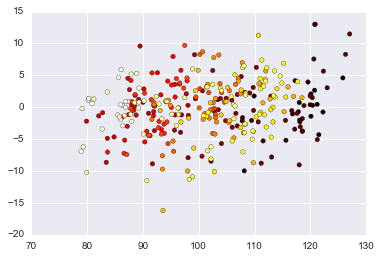

In [53]:
fig, ax = plt.subplots()
phase_plot(horas_industria,ax=ax)

This is in great part explainable by the fact that this series appears to be highly cyclical.

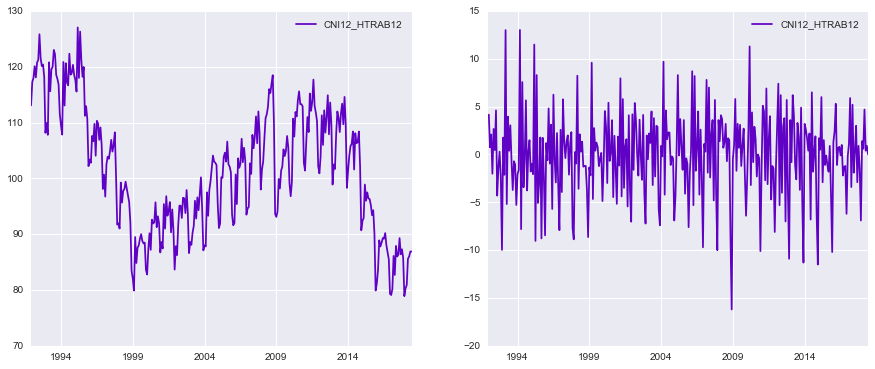

In [36]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,6))
horas_industria.plot(ax=ax[0])
horas_industria.diff().plot(ax=ax[1])

This makes frequency filtering very tempting (and we're actually going to do it). We need of course to always be careful to filter to the frequencies we want to study. To alleviate this need for prior analysis, we'll be looking to cycle (wihin-year behavior) and trend both.

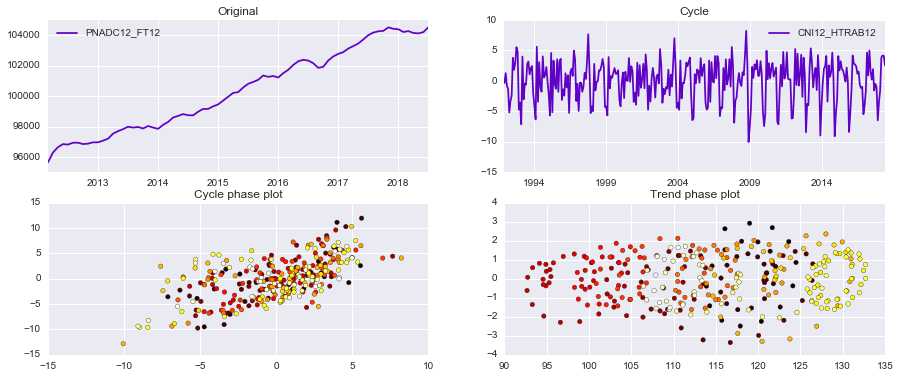

In [50]:
from statsmodels.tsa.filters.cf_filter import cffilter
def freq_analysis_plot(data, low = 2, high = 12):
    cycle, trend = cffilter(data, low = low, high = high)
    fig, ax = plt.subplots(figsize=(15,6), ncols=2, nrows=2)
    desoc.plot(ax = ax[0][0])
    cycle.plot(ax= ax[0][1])
    phase_plot(cycle,ax=ax[1][0])
    phase_plot(trend,ax=ax[1][1])
    titles={(0,0):'Original',(0,1):'Cycle',(1,0):'Cycle phase plot',(1,1): 'Trend phase plot'}
    for u,v in titles: ax[u][v].set_title(titles[(u,v)])
freq_analysis_plot(horas_industria)

Let us compare this behavior to some other employment-related dataset. This is the total # of people outside the workforce.

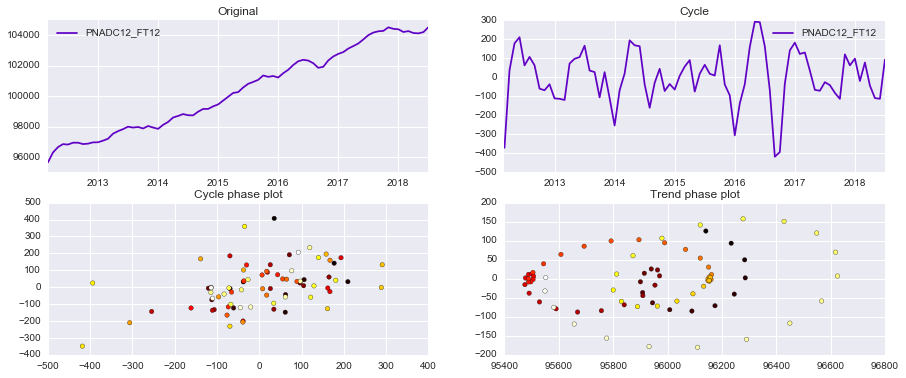

In [51]:
desoc = fixed_series('PNADC12_FT12')
freq_analysis_plot(desoc)

In both cases, the trend phase space looks like an oscillator spiraling out. It possibly means that there is cyclic behavior we haven't smoothed out (because it takes >1 year). Since the latter is a count of people, it may reflect some demographic factors as well? This looks like an interesting chart to discuss with a panel of economists -- there are apparent cycles (which with a colorbar we could date to specific years) and also apparent changes of regime.

The trend phase space is sort of suggestive, but it's easy to jump the gun on the kind of behavior that appears to surface, specially in the second (people count) variable: it would seem that larger values are associated with larger oscillations -- a regression line could be fitted -- which then poses the question of why some months are below-the-average (regression line) and others above-the-average But this could be reading too much into a scatter.

